## Types of Generative Models


1.   **Generative Aversarial Networks**:  Generator and Discriminator, discriminator learns to distinguish the real data from the fake samples that are produced by the generator model. 
2.   ** Variational Autoencoders**: VAE inexplicitly optimizes the log-likelyhood of the data by maximizing the evidence lower bound (ELBO)
3. ** Flow-based** generative models: are constructed by a sequence of invertible transformations. Unlike GANs and VAEs the model explicitly learns the true data distribution $p(\mathbf x)$ and the loss function is simply the negative log-likelihood.


Stolen from From [Lilian Weng's](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html#jacobian-matrix-and-determinant) blog:


![alt text](https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png)

In [ ]:
# check Pillow version
import PIL
print(PIL.PILLOW_VERSION)

4.0.0


In [ ]:
! pip3 install torch

In [ ]:
import os

directory = '/content/results/'
if not os.path.exists(directory):
  os.makedirs(directory)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple
from scipy.stats import norm

In [ ]:
class Gaussian:
    def __init__(self, mu: float = 0, sigma: float = 1, d: int = 1):
        self.mu = mu
        self.sigma = sigma
        self.d = d

    def sample(self, N: int, sort: bool = True) -> np.ndarray :
        sample = np.random.normal(self.mu, self.sigma, size=(N, self.d))
        
        if sort:
          sample.sort(axis=0)
        
        return sample.reshape(N, self.d)


class Noise(object):
    def __init__(self, domain: Tuple[float], scale: float = 0.01):
        self.domain = domain
        self.scale = scale

    def sample(self, N: int) -> np.ndarray:
        ''' Samples from the Noise distribution

        Use stratified sampling to obtain sorted uniform numbers:
          - generate M equally spaced points within specified range 
          - randomly jitter the points 
        '''
        sample = np.linspace(*self.domain, N)
        sample += np.random.random(N) * self.scale

        return sample.reshape(-1, 1)

In [ ]:
mu, sigma =  -1, 1
domain = (-5, 5)

g = Gaussian(mu, sigma, d=1)
z = Noise(domain)

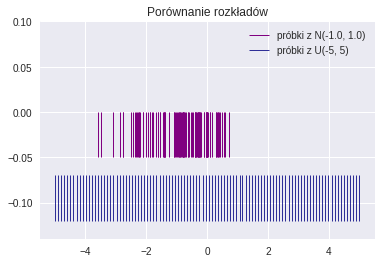

In [ ]:
#@title
# Samples
N = 100
B = 10

xs = np.linspace(*domain, N)
g_samples = g.sample(N)
z_samples = z.sample(N)

# Plot distributions 
m = 0.02
plt.vlines(g_samples, ymin=-0.05,    ymax=-0.0,      color='purple', linewidth = 1, label='próbki z N(%.1f, %.1f)' % (mu, sigma));
plt.vlines(z_samples, ymin=-0.1 - m, ymax=-0.05 - m, color='navy', linewidth = 1, label='próbki z U(%d, %d)' % domain, alpha=.8);

# Make it pretty


plt.ylim(top=0.1, bottom = -0.1 - 2*m);
plt.title('Porównanie rozkładów');
plt.legend() ;

In [ ]:
#@title
from typing import List, Optional
from math import ceil, floor
from matplotlib import animation

def plot_densities(dist: Gaussian, n_samples: int = 256,
                   samples: Optional[np.ndarray] = None,
                   scores: Optional[np.ndarray] = None,
                   domain: Optional[Tuple[float]] = None,
                   m: float = 0.01, 
                   B: int = 10,
                   title: str = 'GAN vs 1D Gaussian'
                  ):
    # Samples
    if samples is None:
        samples = dist.sample(n_samples)
        
    plt.vlines(samples, ymin=-0.05, ymax=-0.0, color='purple', linewidth = 1, 
               label=f"samples ~ N({dist.mu}, {dist.sigma})");

    # Plot the generated distribution
    ## True density
    if not domain:
      domain = (floor(dist.mu - 3*dist.sigma), ceil(dist.mu + 3*dist.sigma))
      
    
    xs = np.linspace(*domain, n_samples)
    plt.plot(xs, norm.pdf(xs, loc=dist.mu, scale=dist.sigma), 
             'r-', color='violet', alpha=0.6,
             label=f"Density N({dist.mu}, {dist.sigma})")

    ## Empirical density
    bins = np.linspace(*domain, B)
    hist, _ = np.histogram(samples, bins = B, density=True, range=domain)
    
    plt.plot(bins, hist, 
             '.--', color='purple', 
             label=f"Est. denisty N({dist.mu}, {dist.sigma})");
    
    ## Discriminator values
    if scores is not None:
      xs = np.linspace(*domain, n_samples)
      plt.plot(xs, scores, alpha=0.8, label='Discriminator values')

    # Make it pretty

    plt.ylim(top=1.2, bottom = -0.1 - 2*m)
    plt.xlim(xmin=domain[0]*1.1, xmax=domain[-1]*1.1)
    plt.title(title)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend() 



def samples(
    G, D,
    fixed_noise: np.ndarray,
    dist: Gaussian,
    domain: Optional[Tuple[float]] = None,
    bins: int = B):
    '''
    Return a tuple (db, pd, pg), where db is the current decision
    boundary, pd is a histogram of samples from the data distribution,
    and pg is a histogram of generated samples.
    '''
    
    if not domain:
      domain = (floor(dist.mu - 3*dist.sigma), ceil(dist.mu + 3*dist.sigma))
      
    # shared xs
    xs = np.linspace(*domain, len(fixed_noise))

    # D scores
    s = D(Tensor(xs.reshape(-1, 1))).detach().numpy()

    # data distribution
    d = norm.pdf(xs, loc=dist.mu, scale=dist.sigma)
    
    # generated samples
    samples = G(Tensor(fixed_noise)).detach().numpy()
    g, _ = np.histogram(samples, bins=bins, density=True, range=domain)

    return s, d, g, domain
  

def save_animation(
    anim_path:str,
    anim_frames: List[Tuple[np.ndarray]]):
    '''
    Saves animation of the training process
    '''
    s, d, g, domain = anim_frames[0]
    
    
    f, ax = plt.subplots()
    f.suptitle('GAN vs 1D Gaussian', fontsize=15)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    
    ax.set_xlim(1.1*domain[0], 1.1*domain[-1])
    ax.set_ylim(-0.12, 1.2)
    
    line_s, = ax.plot([], [], label='Discriminator values')
    line_d, = ax.plot([], [], 'r-', label='True density', color='violet', alpha=0.6)
    line_g, = ax.plot([], [], '.--', color='purple', label='Generated data')

    frame_number = ax.text(
        0.02,
        0.06,
        '',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
    )
    ax.legend()

    
    s_x = np.linspace(*domain, len(s))
    d_x = np.linspace(*domain, len(d))
    g_x = np.linspace(*domain, len(g))
    

    def init():
        line_s.set_data([], [])
        line_d.set_data([], [])
        line_g.set_data([], [])
        
        frame_number.set_text('')
        return (line_s, line_d, line_g, frame_number)

    def animate(i):
        frame_number.set_text(
            'Frame: {}/{}'.format(i, len(anim_frames))
        )
        s, d, g, _ = anim_frames[i]
        line_s.set_data(s_x, s)
        line_d.set_data(d_x, d)
        line_g.set_data(g_x, g)
        
        return (line_s, line_d, line_g, frame_number)

    anim = animation.FuncAnimation(
        f,
        animate,
        init_func=init,
        frames=len(anim_frames),
        blit=True
    )
    anim.save(anim_path, fps=2, extra_args=['-vcodec', 'libx264'])

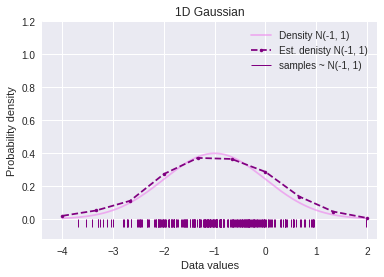

In [ ]:
plot_densities(g, title='1D Gaussian')

# Generative Adversarial Network

In [ ]:
import torch
import torch.nn as nn

from torch import Tensor


def init_weights(module):
    ''' initializes the weights '''
    for name, param in module.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            nn.init.xavier_normal_(param)


class Generator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Generator, self).__init__()
        
        # 1 -> 32 -> 32 -> 1
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True), nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim, bias=True), nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True)
        )
        self.apply(init_weights)
    
    def forward(self, x: Tensor) -> Tensor:
      '''
      Arguments:
        x - 2D tensor of shape B x 1
      
      Returns:
        2D tensor of shape B x 1 with transformed samples
      '''
      return self.net(x)

    
class Discriminator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Discriminator, self).__init__()
        
        # 1 -> 32 -> 1 in (0, 1)
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True),  nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True), nn.Sigmoid()
        )
     
        self.apply(init_weights)
      
    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
        
      

##  KL-divergence
We know the exact "true" distribution, and we can trivially estimate the parameters of the batch of outputs of the generator, with that, we can have an additional 'validation' loss. Let $p(x) = N(\mu_1, \sigma_1) $ and $q(x) = N(\mu_2, \sigma_2)$, then:
\begin{align}
KL(p, q) &= - \int p(x) \log q(x) dx + \int p(x) \log p(x) dx\\\\
&=\frac{1}{2} \log (2 \pi \sigma_2^2) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2} (1 + \log 2 \pi \sigma_1^2)\\\\
&= \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
\end{align}

In [ ]:
def kl_div(mu_1: float, sigma_1: float, 
           mu_2: float, sigma_2: float,  
           eps: float = 1e-6) -> float:
  ''' 
  Close form solution for two univariate gaussians
  '''
  return  np.log(sigma_2/sigma_1 + eps) + \
          (sigma_1**2 + (mu_1 - mu_2)**2)/(2*sigma_2**2 + eps) - 0.5

# Optimalization
Original training criterion
$$
\min_{\theta_g} \max_{\theta_d} \, V(D_{\theta_d}, G_{\theta_g}) = 
  \mathbb{E}_{x} \big[\log D_{\theta_d}(x) \big] + 
  \mathbb{E}_{z} \big[\log(1 - D_{\theta_d}(G_{\theta_g}(z)) \big]
$$

A non-saturating training criterion (the one you will implement):

* Update **D** by ascending its gradient: $\nabla_{\theta_d}   \mathbb{E}_{x} \big[\log D_{\theta_d}(x) \big] +  \mathbb{E}_{z} \big[\log(1 - D_{\theta_d}(G_{\theta_g}(z))\big]$
* Update **G** by ascending its gradient: $\nabla_{\theta_g}   \mathbb{E}_{z} \big[\log(D_{\theta_d}(G_{\theta_g}(z)) \big]$




In [ ]:
def log(x: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    return torch.log(x + eps)
  

def loss_discriminator(real_scores, gen_scores):
    '''
    Calculates the discriminator loss

    Arguments:
      real_scores - D(x)
      gen_scores  - D(G(z))
    '''
    return -torch.mean(log(real_scores) + log(1 - gen_scores))


def loss_generator(gen_scores):
    '''
    Calculates the generator loss

    Arguments
      gen_scores - D(G(z))
    '''
    return -torch.mean(log(gen_scores))

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

batch_size = 256
num_epochs = 3000
epochs_per_frame = 60

# Distributions
mu, sigma = -1.0, 1
g = Gaussian(mu, sigma)
latent = Noise((-4, 2))

# Models
G = Generator(hidden_dim=8)
D = Discriminator(hidden_dim=32)

# Setup Adam optimizers for both G and D
lr = 0.001   # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

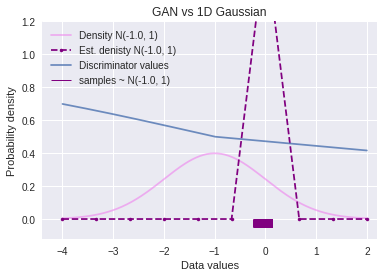

In [ ]:
# Before training
fixed_noise = latent.sample(batch_size)
g_sample = G(Tensor(fixed_noise))
d_sample = D(Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1)))

plot_densities(
    dist = g,
    samples = g_sample.detach().numpy(), 
    scores = d_sample.detach().numpy())

0 0.09214747
100 0.010689195
200 0.0043913205
300 0.0028515435
400 0.0027246815
500 0.002206051
600 0.0017369279
700 0.0015362784
800 0.0013981486
900 0.0013304098


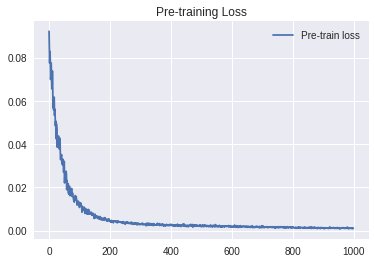

In [ ]:
# Pre-training discriminator
num_epochs_pre = 1000

# optimizer
optimizer = torch.optim.Adam(D.parameters(), lr=lr)

# Loss function
pre_criterion = nn.MSELoss()

D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    x = Variable(Tensor(g.sample(batch_size)))
    y = Variable(Tensor(norm.pdf(x, loc=g.mu, scale=g.sigma)))

    # Train model
    optimizer.zero_grad()
    D_pre_decision = D(x)
    D_pre_loss = pre_criterion(D_pre_decision, y)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.data.numpy())
      
# Plot loss
plt.plot(D_pre_losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend();

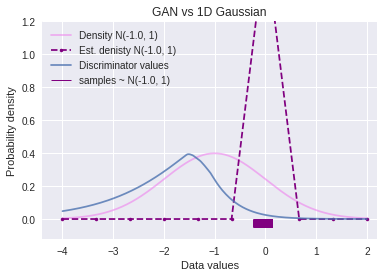

In [ ]:
# After pre-training
d_xs = Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1))
d_sample = D(d_xs)

plot_densities(
    dist = g,
    samples = g_sample.detach().numpy(), 
    scores = d_sample.detach().numpy())

In [ ]:
# Loss function
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)


D_losses, G_losses, KL_losses = [], [], []
anim_frames = []
for epoch in range(num_epochs):
  ############################
  # 1 Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
  ############################
  
  # Zero the gradients
  D.zero_grad()
  
  # Generate batch of real examples
  x = Variable(Tensor(g.sample(batch_size)))
  
  # Forward the batch of reals through Discriminator
  D_real = D(x)  
 
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  # Note: we don't want gradients to flow to G at this point
  D_fake = D(G(z).detach())
             
  # Calculate D's loss on fake batch
  D_loss = loss_discriminator(D_real, D_fake)
             
  # Calculate gradients for D in backward pass
  D_loss.backward()
 
  # Update paramaters of the discriminator
  optimizerD.step()
  
  ############################
  # 2 Train Generator: maximize log(D(G(z)))
  ############################
  # Zero the gradients
  D.zero_grad()
  G.zero_grad()
  
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  # Note: We updated D, perform another forward pass of fake batch through D
  G_loss = loss_generator(D(G(z)))
  
  # Calculate gradients for D in backward pass
  G_loss.backward()
  
  # Update paramaters of the generator
  optimizerG.step()

  
  # Calculate the KL divergence
  g_z = G(z)
  KL_loss = kl_div(
      torch.mean(g_z).item(), torch.std(g_z).item(), 
      g.mu, g.sigma
  )

  
  # Save loss values for plot
  D_losses.append(D_loss.item())
  G_losses.append(G_loss.item())
  KL_losses.append(KL_loss)
  
  if epoch % 100 == 0:
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f mu: %.4f, sigma: %.4f, KL: %.4f' 
          % (epoch, num_epochs, D_loss.item(), G_loss.item(), mu, sigma, KL_loss))

    
  if epoch % epochs_per_frame == 0:
    anim_frames.append(samples(G, D, fixed_noise, g))

[0/3000] Loss_D: 1.6346 Loss_G: 1.3686 mu: -1.0000, sigma: 1.0000, KL: 2.2150
[100/3000] Loss_D: 1.4939 Loss_G: 0.7504 mu: -1.0000, sigma: 1.0000, KL: 0.5996
[200/3000] Loss_D: 1.3737 Loss_G: 0.7640 mu: -1.0000, sigma: 1.0000, KL: 0.3617
[300/3000] Loss_D: 1.3304 Loss_G: 0.7159 mu: -1.0000, sigma: 1.0000, KL: 0.5008
[400/3000] Loss_D: 1.2882 Loss_G: 0.7355 mu: -1.0000, sigma: 1.0000, KL: 0.3343
[500/3000] Loss_D: 1.2519 Loss_G: 0.8456 mu: -1.0000, sigma: 1.0000, KL: 0.1796
[600/3000] Loss_D: 1.3861 Loss_G: 0.6807 mu: -1.0000, sigma: 1.0000, KL: 0.0750
[700/3000] Loss_D: 1.3720 Loss_G: 0.7424 mu: -1.0000, sigma: 1.0000, KL: 0.1563
[800/3000] Loss_D: 1.3414 Loss_G: 0.7288 mu: -1.0000, sigma: 1.0000, KL: 0.0239
[900/3000] Loss_D: 1.3594 Loss_G: 0.7288 mu: -1.0000, sigma: 1.0000, KL: 0.0017
[1000/3000] Loss_D: 1.3766 Loss_G: 0.7034 mu: -1.0000, sigma: 1.0000, KL: 0.0059
[1100/3000] Loss_D: 1.3773 Loss_G: 0.7275 mu: -1.0000, sigma: 1.0000, KL: 0.0249
[1200/3000] Loss_D: 1.3738 Loss_G: 0.707

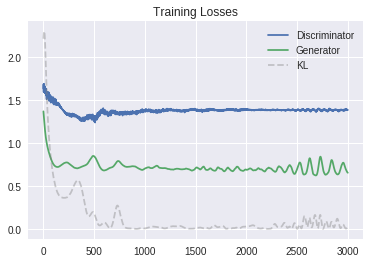

In [ ]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.plot(KL_losses, label='KL', linestyle = '--', alpha=0.4, color='grey')
plt.title("Training Losses")
plt.legend()
plt.show()

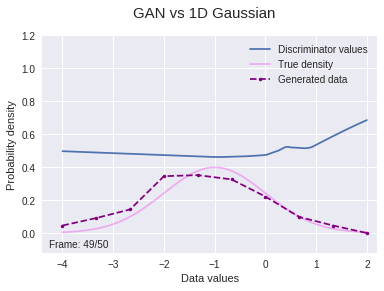

In [ ]:
save_animation('training.mp4', anim_frames)

In [ ]:
from google.colab import files
files.download('training.mp4')